# Biosensor machine learning demo notebook

Tyler W. H. Backman

In [1]:
import numpy
import itertools
from IPython.display import display

# import cheminformatics library
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

# import ML library
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline

### Start by computing features with RDKit

In [2]:
allCompoundsFile = Chem.SDMolSupplier('working/ChnRCompounds.sdf')
detectableCompoundsFile = Chem.SDMolSupplier('working/DetectableCompounds.sdf')

In [3]:
allCompounds = [x for x in allCompoundsFile]
detectableCompounds = [x for x in detectableCompoundsFile]
[len(allCompounds), len(detectableCompounds)]

[29, 11]

In [4]:
info = {}
features = [list(AllChem.GetMorganFingerprintAsBitVect(x,2,nBits=2056,useFeatures=True, bitInfo=info))
            for x in allCompounds]
features = numpy.array(features)

In [5]:
detectables = [x.GetProp('_Name') for x in detectableCompounds]
outcomes = [x.GetProp('_Name') in detectables for x in allCompounds]

### Now that we computed the features, cross-validate different ML models to predict outcome

In [6]:
# split data into 100 random training and testing sets for cross validation
cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=42)

# print the first 10 just to see what this looks like
for train_index, test_index in list(cv.split(features))[0:10]:
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [13 15 11 17  1  4  5  2 24  3 23 25 18 28 20  7 10 14 19  6] TEST: [27 16 12 22  8  9 21  0 26]
TRAIN: [27 23 21 16  3  1 17  8  6  4  2 19 11 18 24 14 15  9 28 26] TEST: [ 0  5 20 25 13  7 22 10 12]
TRAIN: [27 25 20 15 18  9 22  5  1 21 26 17  3 16 13  2 14  7 11  6] TEST: [ 4 24 10  0  8 19 28 12 23]
TRAIN: [ 2 10 19 27 11 18  7 21  6  0 22 24  8 26 28 14 17 12 15 20] TEST: [ 3  1  4  5 16 25  9 13 23]
TRAIN: [18 12 20 17 10  5 23 22  2  4 15  0  1 11  7 26 28  8 25  6] TEST: [14  3 27 19 24 21  9 16 13]
TRAIN: [ 5  2 23 22 15 21 28 10 14 26 24  4  3 19 16  6 18 12  9 25] TEST: [17 11  7 13  0 27 20  8  1]
TRAIN: [20  4 17 24  7  5 23  2  8 12 25 21  0  6 22 10 19 28 11 27] TEST: [14 13 18 15  9 26  3  1 16]
TRAIN: [10  0 20 24  5 27 17 23 18 26 21  4 28  2  1  6 11 19 25 16] TEST: [ 9  8  7 12  3 14 15 13 22]
TRAIN: [ 2 18 17 11  8  0 24 15 25 26  1 19  4  5 16 23 10 28  3 22] TEST: [12 14 21 20  6  7  9 13 27]
TRAIN: [28  3 24 16 11 21  2  9 10 23 22 17 26  7  0  8 27  6 19

In [7]:
def crossVal(classifier):
    # this function takes a classifier, and prints out it's score
    scores = cross_val_score(classifier, features, outcomes, cv=cv)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))    

In [8]:
# test Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
crossVal(GaussianNB())

Accuracy: 0.55 (+/- 0.18)


In [9]:
# test RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
crossVal(RandomForestClassifier(n_estimators=100, max_depth=5, random_state=12, n_jobs=1))

Accuracy: 0.73 (+/- 0.13)


In [10]:
# test C-Support Vector Classification
from sklearn import svm
crossVal(svm.SVC(gamma=0.001, C=100.0))

Accuracy: 0.74 (+/- 0.12)


In [11]:
# test Linear Support Vector Classification
crossVal(svm.LinearSVC())

Accuracy: 0.71 (+/- 0.13)


In [1]:
# test Bernoulli Restricted Boltzmann Machine (RBM)
from sklearn.neural_network import BernoulliRBM
cls_svm2 = svm.SVC( gamma=0.001, C=100. )
rbm = BernoulliRBM(random_state = 0, verbose = True)
classifier = Pipeline( steps=[("rbm", rbm), ("cls_svm2", cls_svm2)] )
rbm.learning_rate = 0.06
rbm.n_iter = 20
rbm.n_compornents = 1000
crossVal(classifier)

NameError: name 'svm' is not defined

#### Now let's inspect how well the model predicts it's own training data, using the best model from above

In [13]:
classifier = svm.SVC(gamma=0.001, C=100.0, probability=True)
classifierFit = classifier.fit(features, outcomes)

In [14]:
predictions = classifierFit.predict(features)

In [15]:
print('cid\t\toutcome\tprediction')
for i in range(0, len(outcomes)):
    print(allCompounds[i].GetProp('_Name') + ':\t\t' + str(outcomes[i]) + '\t' + str(predictions[i]))

cid		outcome	prediction
7714:		False	False
136887:		True	True
11419:		True	True
7965:		False	False
11829404:		True	True
10952:		False	True
7960:		True	True
7966:		True	True
7967:		True	True
12025:		True	True
12665:		True	True
7768:		True	True
7704:		False	False
7710:		False	False
11559:		False	False
13204:		False	False
281856:		False	False
7742:		True	False
12756:		True	False
5325915:		False	False
12810:		False	False
12844:		False	False
520296:		False	False
61204:		False	False
12777:		False	False
18698:		False	False
39914:		False	False
6419891:		False	False
54675757:		False	False


In [16]:
# Confusion matrix report structure: 

# True negatives, false negatives
# false positives, true positives
print(metrics.confusion_matrix(outcomes, predictions))

[[17  1]
 [ 2  9]]


In [17]:
# precision: the ability of the classifier not to incorrectly classify into this category
# recall: the ability of the classifier to classify into this category correctly
# support: 
print(metrics.classification_report(outcomes, predictions))

             precision    recall  f1-score   support

      False       0.89      0.94      0.92        18
       True       0.90      0.82      0.86        11

avg / total       0.90      0.90      0.90        29



In [18]:
# compute the probabilities of [False, True] outcomes
classifierFit.predict_proba(features)

array([[ 0.78089503,  0.21910497],
       [ 0.314824  ,  0.685176  ],
       [ 0.31478619,  0.68521381],
       [ 0.74814644,  0.25185356],
       [ 0.31474904,  0.68525096],
       [ 0.49136788,  0.50863212],
       [ 0.49136788,  0.50863212],
       [ 0.36672243,  0.63327757],
       [ 0.31474786,  0.68525214],
       [ 0.29873262,  0.70126738],
       [ 0.31472922,  0.68527078],
       [ 0.31472922,  0.68527078],
       [ 0.78089503,  0.21910497],
       [ 0.78089503,  0.21910497],
       [ 0.78097678,  0.21902322],
       [ 0.78092154,  0.21907846],
       [ 0.78084012,  0.21915988],
       [ 0.76630794,  0.23369206],
       [ 0.69499571,  0.30500429],
       [ 0.78091281,  0.21908719],
       [ 0.78089503,  0.21910497],
       [ 0.78089503,  0.21910497],
       [ 0.78089503,  0.21910497],
       [ 0.78089503,  0.21910497],
       [ 0.78089503,  0.21910497],
       [ 0.78089503,  0.21910497],
       [ 0.78088829,  0.21911171],
       [ 0.78092462,  0.21907538],
       [ 0.78082909,

### Use the Feature importances function of RandomForestClassifier to identify and plot the most predictive chemical substructures

In [19]:
classifier = RandomForestClassifier(max_depth=5, random_state=12, n_jobs=1)
classifierFit = classifier.fit(features, outcomes)

In [20]:
importance = classifierFit.feature_importances_

In [21]:
importantFeatures = numpy.argsort(importance)[::-1][0:10]
for feature in importantFeatures:
    print(importance[feature])

0.129285002805
0.105317908911
0.0814999584269
0.0736173646413
0.0559402256422
0.0487401278676
0.0432484510697
0.0371190736064
0.034764918214
0.0279694359378


Loop over most important features and plot which compounds have them

In [22]:
def getAtomList(compound, atom, radius):
    env = Chem.FindAtomEnvironmentOfRadiusN(compound,radius,atom)
    amap={}
    submol=Chem.PathToSubmol(compound,env,atomMap=amap)
    return list(amap.keys())

Feature #291
fraction active:	 0.09


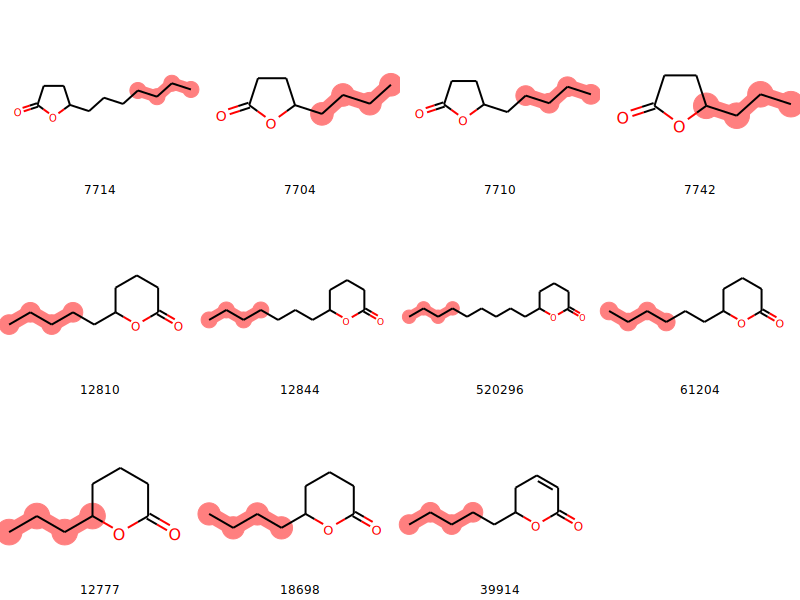

Feature #280
fraction active:	 0.38


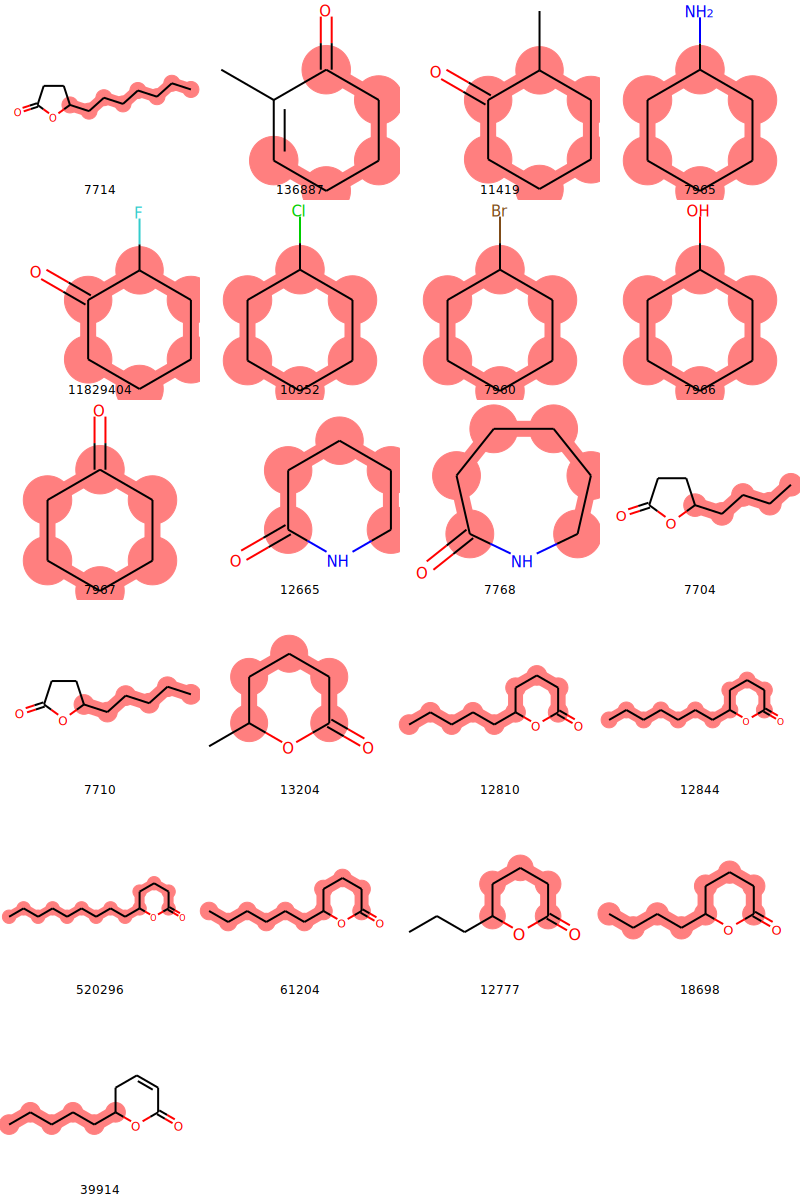

Feature #1268
fraction active:	 1.00


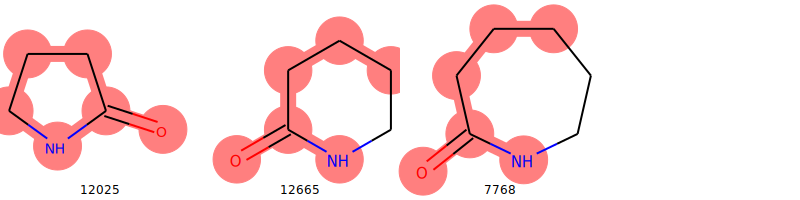

Feature #56
fraction active:	 0.15


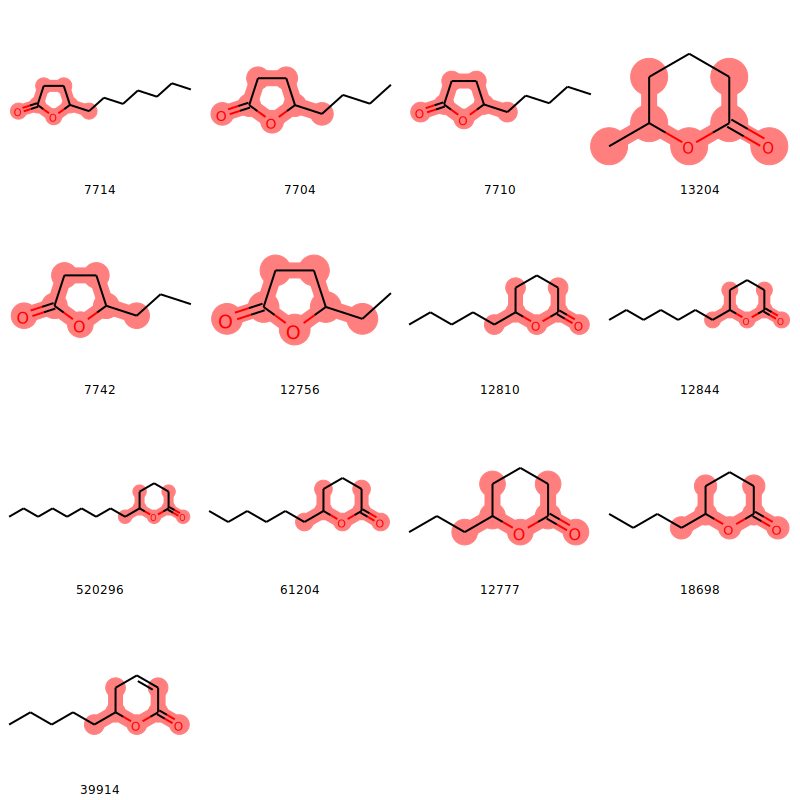

Feature #515
fraction active:	 1.00


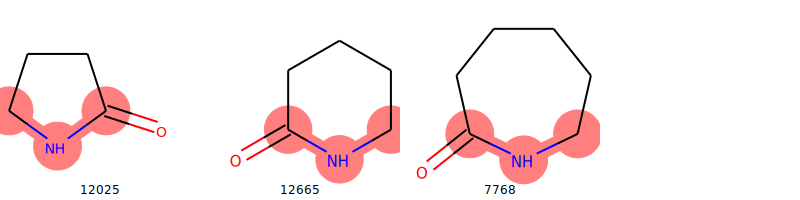

Feature #1187
fraction active:	 1.00


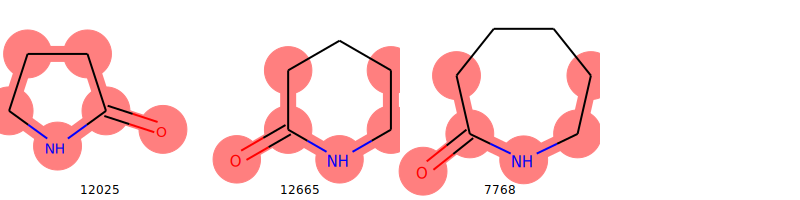

Feature #1395
fraction active:	 1.00


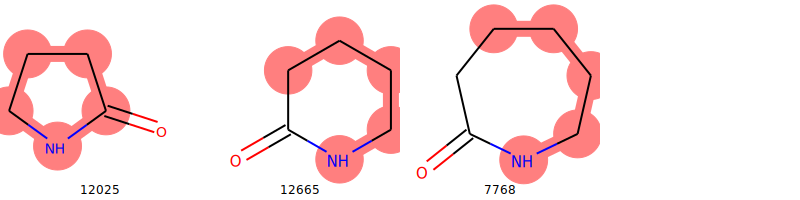

Feature #2
fraction active:	 0.36


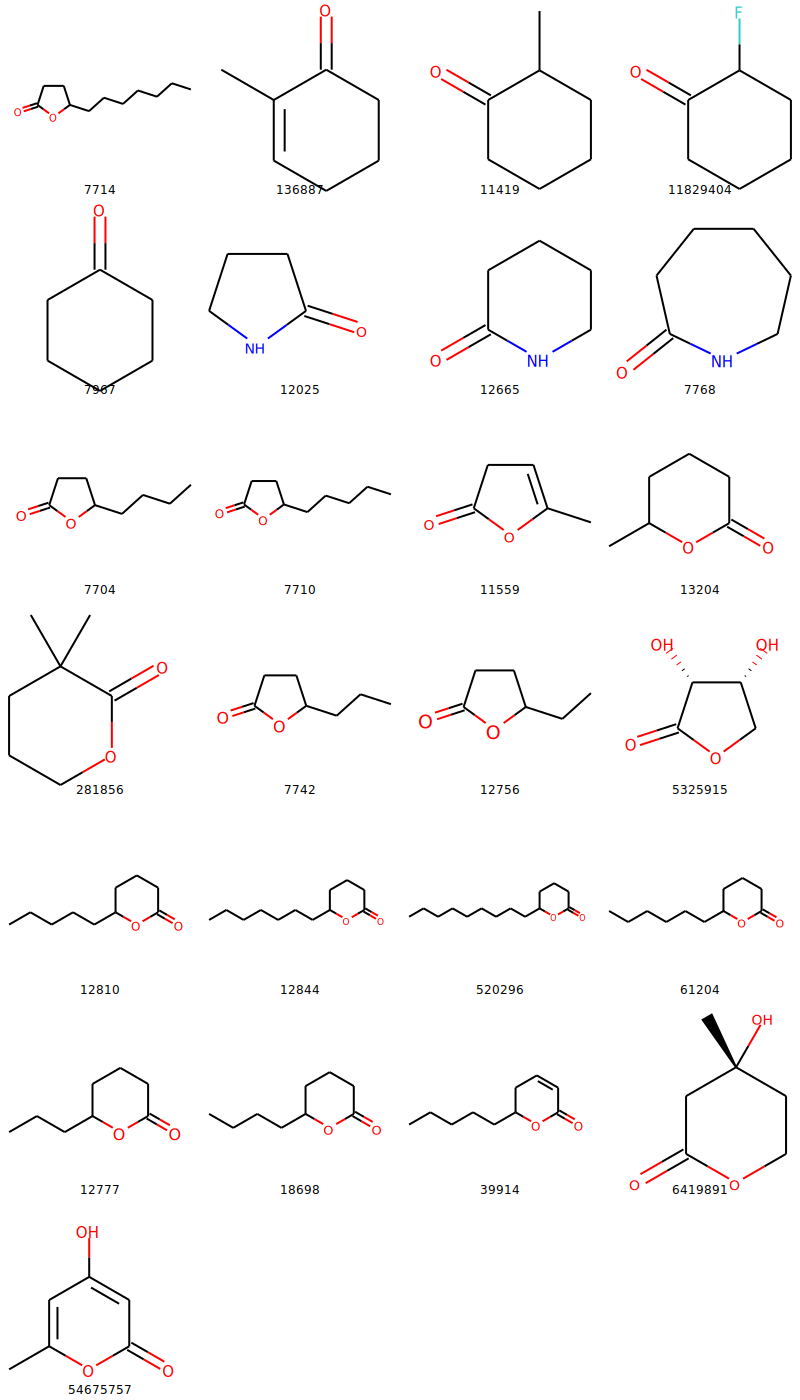

Feature #267
fraction active:	 1.00


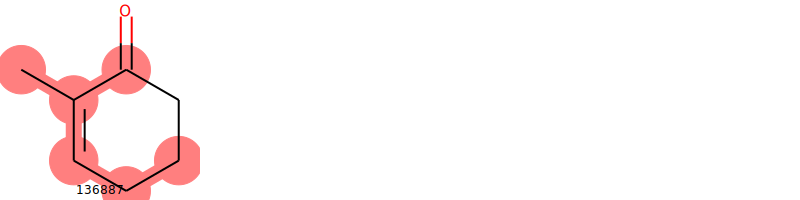

Feature #526
fraction active:	 0.00


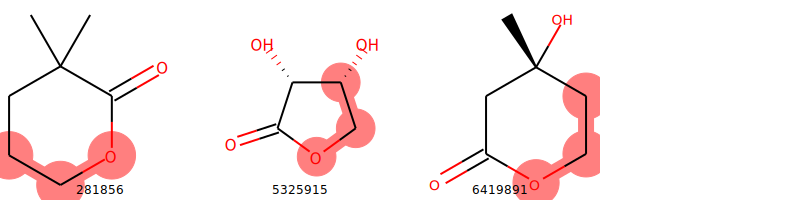

In [25]:
for importantFeature in importantFeatures:
    compoundIndex = list(numpy.where(features[:,importantFeature])[0])
    print("Feature #" + str(importantFeature))
    print("fraction active:\t %0.2f" % (sum([outcomes[i] for i in compoundIndex]) / len(compoundIndex)))
    compounds = []
    highlight = []
    legends = []

    for i in compoundIndex:
        compound = allCompounds[i]
        compounds.append(compound)
        legends.append(compound.GetProp('_Name'))
    
        # get bit info for this fingerprint
        info={}
        fp=AllChem.GetMorganFingerprintAsBitVect(compound,2,nBits=2056,useFeatures=True,bitInfo=info)
        featureCoords = info[importantFeature]
        featureCoords
    
        # get atoms to highlight
        z = [getAtomList(compound, x[0], x[1]) for x in featureCoords]
        highlightAtomList = list(set(itertools.chain.from_iterable(z)))
        highlight.append(highlightAtomList)
        
    # plot this feature    
    image = Draw.MolsToGridImage(compounds, highlightAtomLists=highlight, 
        legends=legends, molsPerRow=4, useSVG=True)
    display(image)